<a href="https://colab.research.google.com/github/jdxxmahmud/Paper-Implementation---Automatic-Segmentation-of-Blood-Cells/blob/main/Automatic_Segmentation_of_Blood_Cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content

/content


In [3]:
from google.colab import userdata
import os
# Replace with your actual directory
dir = userdata.get("CURR_DIR")

try:
  os.chdir(dir)
  print(f"Current working directory: {os.getcwd()}")
except FileNotFoundError:
  print(f"Directory '{dir}' not found.")


Current working directory: /content/drive/MyDrive/Mahdy Sir/Phase 2/Automatic Segmentation of Blood Cells


In [4]:
%ls

'Automatic Segmentation of Blood Cells.ipynb'   codes/   malaria/   processed/   u_net_model.keras


## File Imports

In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Image
from skimage.io import imread, imshow

# Sklearn
from sklearn.model_selection import train_test_split


# DL
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from keras.optimizers.schedules import ExponentialDecay
from keras.models import Model, load_model
from keras.layers import Input, AvgPool2D
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, Activation, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam

In [6]:
image_dir = 'malaria/images'
images = []
count = 0

for filename in os.listdir(f'{image_dir}'):
    if filename.endswith(".png") and count < 20:
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            count += 1

print(f"Imported {len(images)} images.")


Imported 20 images.


## Show Images

In [10]:
def show_images(image_list, num_images=8):
  """Shows a specified number of images in a 2x4 grid.

  Args:
    image_list: A list of images (NumPy arrays).
    num_images: The number of images to display (default is 8).
  """

  num_images = min(num_images, len(image_list))
  rows = 2
  cols = 4

  fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
  for i in range(num_images):
    row = i // cols
    col = i % cols
    axes[row, col].imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
    axes[row, col].axis('off')

  plt.tight_layout()
  plt.show()



In [11]:
def show_before_after_images(before_images, after_images, num_images=4):
  """Shows a specified number of before and after images in two rows.

  Args:
    before_images: A list of images before processing.
    after_images: A list of images after processing.
    num_images: The number of images to display in each row (default is 4).
  """

  num_images = min(num_images, len(before_images), len(after_images))
  rows = 2
  cols = 4

  fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

  for i in range(num_images):
    # Before image
    axes[0, i].imshow(cv2.cvtColor(before_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f'{i}')
    axes[0, i].axis('off')

    # After image
    axes[1, i].imshow(after_images[i], cmap='gray')
    axes[1, i].set_title(f'{i}')
    axes[1, i].axis('off')

  plt.tight_layout()
  plt.show()

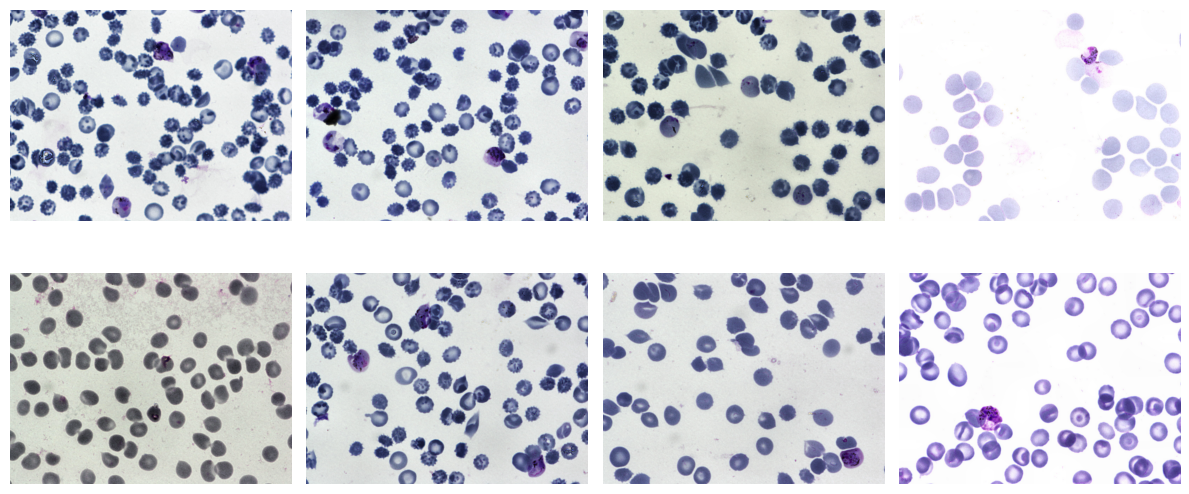

In [12]:
show_images(images)

## Otsu's Method

In [13]:
def otsu_method(image):

    kernel_size=(3, 3)
    iterations_open=3
    iterations_dilate=9

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal with morphological operations
    kernel = np.ones(kernel_size, np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=iterations_open)

    # Sure background area (dilate)
    sure_bg = cv2.dilate(opening, kernel, iterations=iterations_dilate)

    # Sure foreground using distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

    # Convert sure foreground to uint8
    sure_fg = np.uint8(sure_fg)

    # Unknown region by subtracting foreground from background
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    _, markers1 = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that background is labeled 1 instead of 0
    markers = markers1 + 10
    markers[unknown == 255] = 0

    # Apply the watershed algorithm
    markers = cv2.watershed(img, markers)

    # Mark the watershed boundaries on the image
    img[markers == -1] = [255, 255, 255]

    return img, thresh, sure_bg, dist_transform, sure_fg, unknown, markers


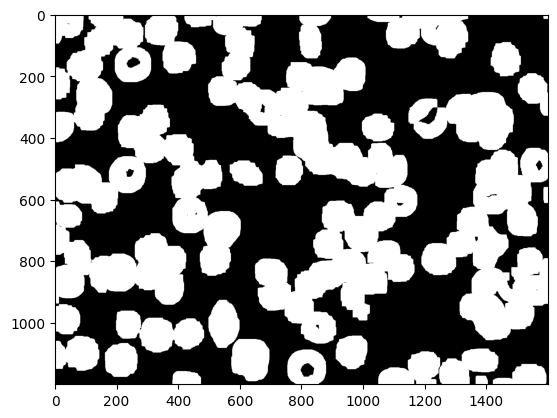

In [14]:
img, thresh, sure_bg, dist_transform, sure_fg, unknown, markers = otsu_method(images[0])
plt.imshow(sure_bg, cmap='gray')
plt.show()

## Applying otsu's method

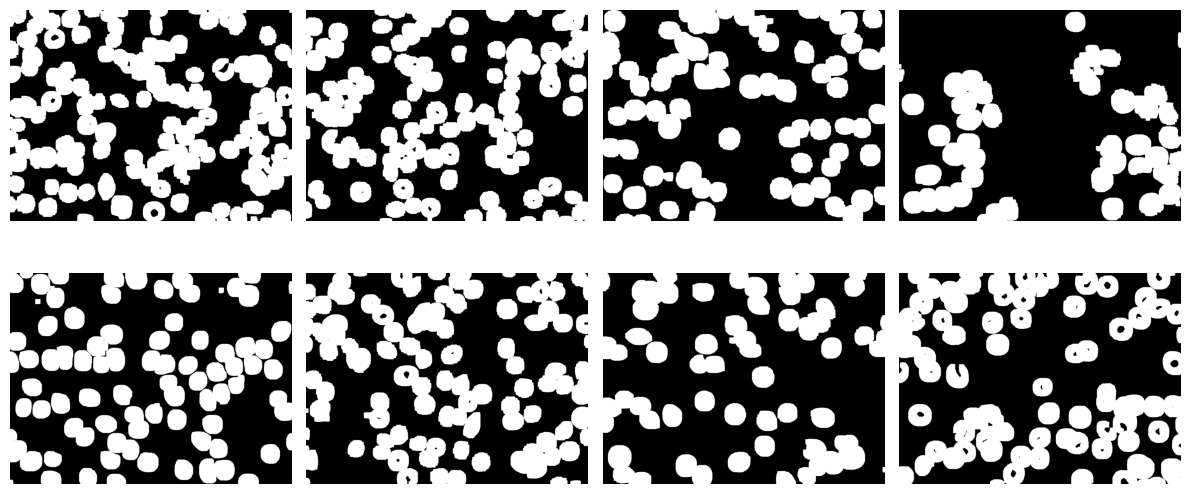

In [15]:
masks = []
for img in images:
    img, thresh, sure_bg, dist_transform, sure_fg, unknown, markers = otsu_method(img)
    masks.append(sure_bg)

show_images(masks)

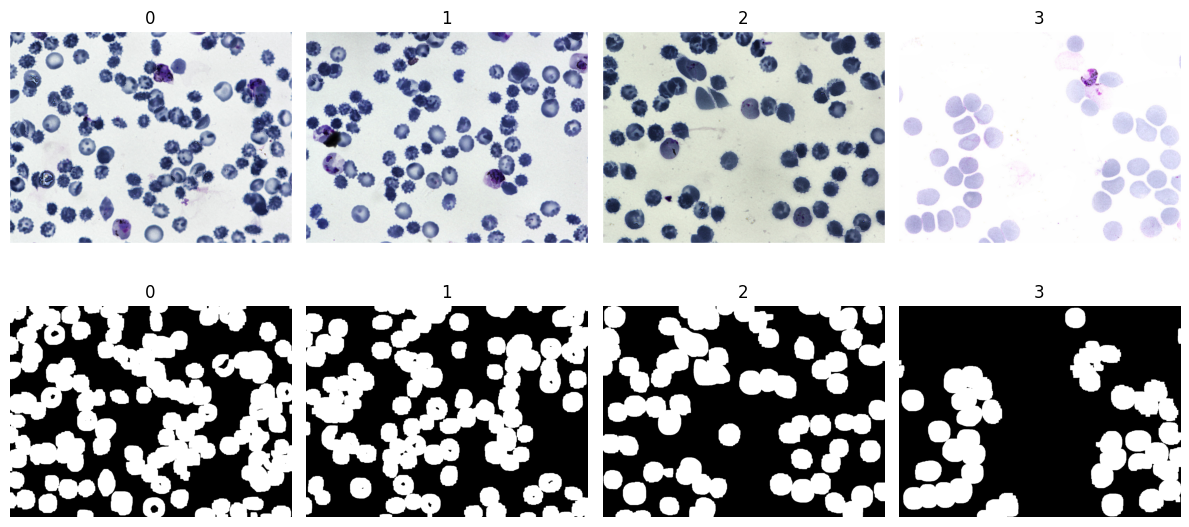

In [16]:
show_before_after_images(images, masks)

## Save Images

In [17]:
def save_images(image_list, directory):

    for i, image in enumerate(image_list):
        image_filename = os.path.join(directory, f'image_{i}.png')
        if not os.path.exists(filename):
            cv2.imwrite(image_filename, image)

In [18]:
mask_dir = 'processed/masks'
image_dir = 'processed/images'

# Create the directory if it doesn't exist
os.makedirs(mask_dir, exist_ok=True)
os.makedirs(image_dir, exist_ok=True)


save_images(masks, mask_dir)
save_images(images, image_dir)


## Augmentation

In [19]:
import albumentations as A

transform = A.Compose([
    # A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=1), # This creates a problem
    # A.RandomRotate90(p=1), # This creates a problem
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(blur_limit=7, always_apply=True, p=0.5),
    A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, always_apply=True, p=0.5),
    A.GaussNoise (var_limit=(10.0, 50.0), mean=0, always_apply=True, p=0.5)
])

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Train Test Split

In [20]:
def split_data(images, masks, test_size=0.2):

  train_x, test_x, train_y, test_y = train_test_split(
                                                    images, masks,
                                                    test_size=test_size,
                                                    random_state=42)

  return train_x, test_x, train_y, test_y

train_x, test_x, train_y, test_y = split_data(images, masks)
print(f"Number of training images: {len(train_x)}")
print(f"Number of testing images: {len(test_x)}")


Number of training images: 16
Number of testing images: 4


In [21]:
aug_train_x = []
aug_train_y = []

for i in range(len(train_x)):

        image = train_x[i]
        mask = train_y[i]

        transformed = transform(image=image, mask=mask)

        aug_train_x.append(transformed['image'])
        aug_train_y.append(transformed['mask'])


print(aug_train_x[0].shape)
print(aug_train_y[0].shape)

(1200, 1600, 3)
(1200, 1600)


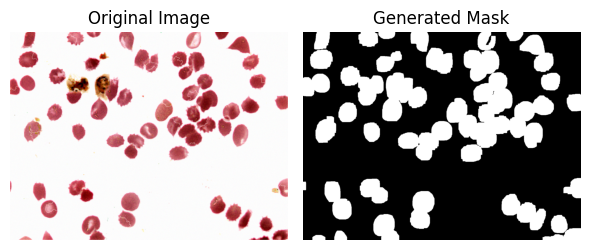

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

idx = np.random.randint(0, len(aug_train_x))

axes[0].imshow(cv2.cvtColor(aug_train_x[idx], cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(aug_train_y[idx], cv2.COLOR_BGR2RGB))
axes[1].set_title("Generated Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Merge Actual and Augmented Data

In [23]:
new_x_train = images + aug_train_x
new_y_train = masks + aug_train_y

shape_x = new_x_train[0].shape
shape_y = new_y_train[0].shape

print(f"Shape of x_train: {shape_x}, Length: {len(new_x_train)}")
print(f"Shape of y_train: {shape_y}, Length: {len(new_y_train)}")

Shape of x_train: (1200, 1600, 3), Length: 36
Shape of y_train: (1200, 1600), Length: 36


## Metrics for training and validation

In [24]:
def dice_coefficient(y_true, y_pred, smooth=1):
    # Convert y_true and y_pred to float32 for calculations
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    # Use TensorFlow constants and operations
    smooth = tf.cast(smooth, dtype=tf.float32)
    two = tf.cast(2.0, dtype=tf.float32)

    return (two * intersection + smooth) / (union + smooth)


def jaccard_index(y_true, y_pred, smooth=1):
    # Convert y_true and y_pred to float32 to ensure compatibility
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate intersection and union using TensorFlow operations
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    # Add smooth to avoid division by zero and return the Jaccard index
    return (intersection + smooth) / (union + smooth)

## Data readiness

In [ ]:
new_x_train = np.array(new_x_train)  # Stack the images into a single array
new_y_train = np.array(new_y_train)


new_y_train = np.expand_dims(new_y_train, axis=-1)  # Add a channel dimension to masks
new_y_train = np.repeat(new_y_train, 3, axis=-1)

print(new_x_train[0].shape)
print(new_y_train[0].shape)

## Model Building

### U-net

In [25]:
def unet_model(input_shape=(256, 256, 3), initial_learning_rate=0.001):

    inputs = Input(input_shape)

    # Normalize inputs
    s = Lambda(lambda x: x / 255) (inputs)

    # Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    # Expansive Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.5,
        staircase=True
    )

    # Compile model with optimizer and loss function
    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coefficient, jaccard_index])

    return model

In [26]:
u_net_model = unet_model(input_shape=new_x_train[0].shape, initial_learning_rate=0.001)
u_net_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1200, 1600, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1200, 1600, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1200, 1600, 16) │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1200, 1600, 16) │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1200, 1600, 16) │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 600, 800, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 600, 800, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 600, 800, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 600, 800, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 300, 400, 32)   │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 300, 400, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 300, 400, 64)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 300, 400, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 150, 200, 64)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 150, 200, 128)  │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 150, 200, 128)  │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 150, 200, 128)  │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 75, 100, 128)   │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
filepath = "./u_net_model.keras"

early_stopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [early_stopper, checkpoint]

u_net_history = u_net_model.fit(new_x_train, new_y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=callbacks_list)

(1200, 1600, 3)
(1200, 1600, 3)
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - dice_coefficient: 1.1303 - jaccard_index: 1.4067 - loss: -108353167360.0000
Epoch 1: val_loss improved from inf to -54047390302208.00000, saving model to ./u_net_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 699ms/step - dice_coefficient: 1.1350 - jaccard_index: 1.4211 - loss: -176580935680.0000 - val_dice_coefficient: 1.3225 - val_jaccard_index: 1.9525 - val_loss: -54047390302208.0000
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - dice_coefficient: nan - jaccard_index: nan - loss: nan
Epoch 2: val_loss did not improve from -54047390302208.00000
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 259ms/step - dice_coefficient: nan - jaccard_index: nan - loss: nan - val_dice_coefficient: nan - val_jaccard_index: nan - val_loss: nan
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - dice_coefficient: nan - jaccard_index: nan - loss: nan
Epoch 3: val_loss did not improve from -54047390302208.00000
28/28 ━━━━━━━━━━━━━━

### U-net++

In [29]:
dropout_rate = 0.5

def conv2d_batchnormalization_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x

In [50]:
def u_net_plusplus_model(input_shape, n_labels, using_deep_supervision=True):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv2d_batchnormalization_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv2d_batchnormalization_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv2d_batchnormalization_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv2d_batchnormalization_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv2d_batchnormalization_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv2d_batchnormalization_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv2d_batchnormalization_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv2d_batchnormalization_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv2d_batchnormalization_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv2d_batchnormalization_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv2d_batchnormalization_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv2d_batchnormalization_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv2d_batchnormalization_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv2d_batchnormalization_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv2d_batchnormalization_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)


    if using_deep_supervision==True:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                            nestnet_output_2])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    lr_schedule = ExponentialDecay(
    initial_learning_rate=0.054,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

    opt = Adam(learning_rate=3e-4)

    #model.compile(optimizer='adam', loss='binary_crossentropy')
    model.compile(optimizer=opt, loss='binary_crossentropy' , metrics=[dice_coefficient, jaccard_index])
    #dice_coef, jaccard_index

    return model

In [51]:
input_shape = new_x_train[0].shape
n_labels = 3
u_net_plusplus__model = u_net_plusplus_model(input_shape, n_labels)
u_net_plusplus__model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 1200, 1600, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_139 (Conv2D)       │ (None, 1200, 1600, 32) │            896 │ input_image[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_120   │ (None, 1200, 1600, 32) │          6,400 │ conv2d_139[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_120            │ (None, 1200, 1600, 32) │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (AveragePooling2D)  │ (None, 600, 800, 32)   │              0 │ activation_120[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_140 (Conv2D)       │ (None, 600, 800, 64)   │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_121   │ (None, 600, 800, 64)   │          3,200 │ conv2d_140[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_121            │ (None, 600, 800, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (AveragePooling2D)  │ (None, 300, 400, 64)   │              0 │ activation_121[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_142 (Conv2D)       │ (None, 300, 400, 128)  │         73,856 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_123   │ (None, 300, 400, 128)  │          1,600 │ conv2d_142[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_123            │ (None, 300, 400, 128)  │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up22 (Conv2DTranspose)    │ (None, 600, 800, 64)   │         32,832 │ activation_123[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up12 (Conv2DTranspose)    │ (None, 1200, 1600, 32) │          8,224 │ activation_121[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merge22 (Concatenate)     │ (None, 600, 800, 128)  │              0 │ up22[0][0],            │
│                           │                        │                │ activation_121[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ merge12 (Concatenate)     │ (None, 1200, 1600, 64) │              0 │ up12[0][0],            │
│                      

 Total params: 289,862 (1.11 MB)

 Trainable params: 276,262 (1.05 MB)

 Non-trainable params: 13,600 (53.12 KB)

In [52]:
filepath = "./u_net_model.keras"

early_stopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min' )
#mode='min'
callbacks_list = [early_stopper, checkpoint]

u_net_plusplus_history = u_net_plusplus__model.fit(new_x_train, new_y_train, validation_split=0.2, batch_size=1, epochs=20, callbacks=callbacks_list)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias', 'kernel', 'bias', 'gamma', 'beta', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: -167.4355 - output_1_dice_coefficient: 1.6087
Epoch 1: val_loss improved from inf to -291.73444, saving model to ./u_net_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 283ms/step - loss: -169.3609 - output_1_dice_coefficient: 1.6130 - val_loss: -291.7344 - val_output_1_dice_coefficient: 1.7915
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: -330.6433 - output_1_dice_coefficient: 1.9041
Epoch 2: val_loss did not improve from -291.73444
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 233ms/step - loss: -331.1304 - output_1_dice_coefficient: 1.9046 - val_loss: -81.2346 - val_output_1_dice_coefficient: 1.3915
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: -483.4710 - output_1_dice_coefficient: 1.9164
Epoch 3: val_loss did not improve from -291.73444
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - loss: -483.5493 - output_1_dice_coefficient: 1.9153 - val_loss: -34.8780 - val_output_1_dice_coefficient: 1.1229
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━